In [1]:
%load_ext notexbook

In [2]:
%texify

# Introduction to PySyft

In a nutshell, PySyft helps organisations securely collaborate with external (untrusted) individuals. By using PySyft, organisations can enable external auditors to use their private assets, in order to conduct a study with a specific, known purpose. 

Besides this, the workflow prevents the external auditor from using the private assets for any other purpose. 
This is called **secure external access**.

There are two types of assets that an organisation can have:
- private datasets
- private models: already-trained ML models

## The Workflow

<img src="./syft_workflow.png" />

In a nutshell:

- The organization (i.e. Data Owner, `DO`) uses PySyft to host **private data** along with a **mock** version of the dataset.
- The Data Scientist (`DS`) submits gets access to the PySyft domain, and starts thinkering with the _mock_ dataset.
    - Private data **cannot** be accessed at this stage by the DS.
- Once ready, the DS submits their proposal and code to work on private data on the PySyft node.
- The DO receives and reviews the request, comparing it to organization's data policies, and legal requirements.
- If compliant, the DO runs the code against the private data, and deposits the result.
- DS receives and download the result.

---

## Use Case: Using PySyft to study Breast Cancer

### Preamble 

Roles placeholder used throughout the notebook

**Alice** 🧝‍♀️ 

_Service Role_: Data Owner 

**Bob** 🧙‍♂️

_Service Role_: Data Scientist

### Alice 🧝‍♀️: Generate and Upload Data

First we'll create a private dataset and a mock dataset and then upload each to the domain server.

In [3]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

In [4]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [5]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In this simple case, let's start creating a mock version of the true (private) data by adding to each value the _mean_ value of each feature (i.e. column)

In [6]:
mock_X = X.apply(lambda s: s+np.mean(s))

In [7]:
# let's attach labels as (last) column
X["y"] = y
mock_X["y"] = y

private_data = X
mock_data = mock_X

---

In [8]:
import syft as sy

domain_node = sy.orchestra.launch(port="8083", name="pet-test-domain", reset=True)

Starting pet-test-domain server on 0.0.0.0:8083
Waiting for server to start. Done.


Logged into <pet-test-domain: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

<DomainClient: pet-test-domain>
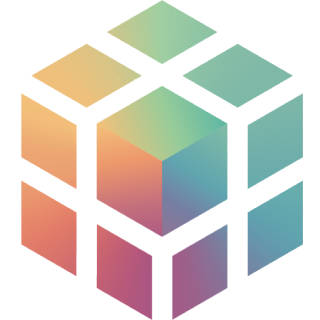

In [9]:
client = sy.login(port="8083", email="info@openmined.org", password="changethis")
client

#### Uploading data to the client

In [13]:
dataset = sy.Dataset(
    name="Winsconsin Breast Cancer Data",
    description="Breast cancer wisconsin (diagnostic) dataset",
    citation = "O.L. Mangasarian, W.N. Street and W.H. Wolberg. Breast cancer diagnosis and \
    prognosis via linear programming. Operations Research, 43(4), pages 570-577, \
    July-August 1995.",
    url="https://goo.gl/U2Uwz2"
)
data_asset = sy.Asset(
    name="Breast Cancer Data", 
    data=private_data,
    mock=mock_data)

dataset.add_asset(data_asset)

SyftSuccess: Asset 'Breast Cancer Data' added to 'Winsconsin Breast Cancer Data' Dataset.

In [14]:
dataset

syft.service.dataset.dataset.CreateDataset

In [15]:
client.upload_dataset(dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Uploading: Breast Cancer Data


SyftSuccess: Dataset uploaded to 'pet-test-domain'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

In [16]:
client.datasets

#### Create Data Scientist Account

Next we'll create our data scientist role that can log into our domain only.

In [17]:
from syft.service.user.user_roles import ServiceRole
from syft.service.user.user import UserCreate

In [18]:
ds_profile = UserCreate(
    email="bob@security.edu",
    name="Bob Science",
    role=ServiceRole.DATA_SCIENTIST,
    password="abc123",
    password_verify="abc123",
    institution="Security Institute",
    website="security.edu",
)

client.users.create(ds_profile)

```python
class UserView:
  id: str = 02aa63d507d049128fc8374fbfb3daf4
  name: str = "Bob Science"
  email: str = "bob@security.edu"
  institution: str = "Security Institute"
  website: str = "security.edu"
  role: str = ServiceRole.DATA_SCIENTIST
  notifications_enabled: str = {<NOTIFIERS.EMAIL: 1>: True, <NOTIFIERS.SMS: 2>: False, <NOTIFIERS.SLACK: 3>: False, <NOTIFIERS.APP: 4>: False}

```

---

### Bob 🧙‍♂️: Submitting requests to the domain 

Let's switch hats and pretend we are now the Data Scientist, thus we connect to the domain using our own credentials.

In [19]:
scientist_domain = domain_node.client

Logged into <pet-test-domain: High-side Domain> as GUEST


Logged into <pet-test-domain: High side Domain> as <bob@security.edu>


<DomainClient: pet-test-domain>
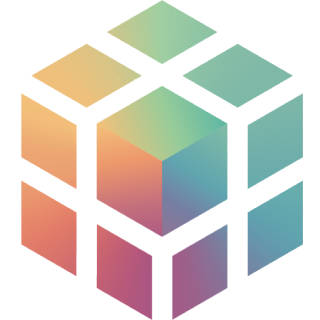

In [20]:
scientist_client = scientist_domain.login(email="bob@security.edu", password="abc123")
scientist_client

Now, **Bob** can access the datasets and assets on the domain:

In [21]:
scientist_client.datasets

In [22]:
scientist_client.datasets[0]

syft.service.dataset.dataset.Dataset

In [23]:
assets = scientist_client.datasets[0].assets

# Success!

In [24]:
list(assets.keys())

['Breast Cancer Data']

In [25]:
asset = assets[0]

In [26]:
asset.mock

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,32.117292,29.669649,214.769033,1655.889104,0.21476,0.381941,0.388899,0.196019,0.423062,0.141508,...,43.007223,291.861213,2899.583128,0.294569,0.919865,0.984088,0.380006,0.750176,0.202846,0
1,34.697292,37.059649,224.869033,1980.889104,0.18110,0.182981,0.175699,0.119089,0.362362,0.119468,...,49.087223,266.061213,2836.583128,0.256169,0.440865,0.513788,0.300606,0.565076,0.172966,0
2,33.817292,40.539649,221.969033,1857.889104,0.20596,0.264241,0.286199,0.176819,0.388062,0.122788,...,51.207223,259.761213,2589.583128,0.276769,0.678765,0.722588,0.357606,0.651376,0.171526,0
3,25.547292,39.669649,169.549033,1040.989104,0.23886,0.388241,0.330199,0.154119,0.440862,0.160238,...,52.177223,206.131213,1448.283128,0.342169,1.120565,0.959088,0.372106,0.953876,0.256946,0
4,34.417292,33.629649,227.069033,1951.889104,0.19666,0.237141,0.286799,0.153219,0.362062,0.121628,...,42.347223,259.461213,2455.583128,0.269769,0.459265,0.672188,0.277106,0.526476,0.160726,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,35.687292,41.679649,233.969033,2133.889104,0.20736,0.220241,0.332699,0.187819,0.353762,0.119028,...,52.077223,273.361213,2907.583128,0.273369,0.465565,0.682888,0.336206,0.496076,0.155096,0
565,34.257292,47.539649,223.169033,1915.889104,0.19416,0.207741,0.232799,0.146829,0.356362,0.118128,...,63.927223,262.261213,2611.583128,0.248969,0.446465,0.593688,0.277406,0.547276,0.150316,0
566,30.727292,47.369649,200.269033,1512.989104,0.18091,0.206641,0.181309,0.101939,0.340162,0.119278,...,59.797223,233.961213,2004.583128,0.246269,0.563665,0.612488,0.256406,0.511876,0.162146,0
567,34.727292,48.619649,232.069033,1919.889104,0.21416,0.381341,0.440199,0.200919,0.420862,0.132958,...,65.097223,291.861213,2701.583128,0.297369,1.122365,1.210888,0.379606,0.698776,0.207946,0


In [27]:
asset.data

#### Using Syft and Machine learning on Data

Now that Bob is familiar with the dataset, he would like to conduct his study to get a privacy-preserving statistical output of the proposed dataset. 

To do so, we will start by tinkering with mock data, in order to prepare our code request to finally submit to `DO` to review.

<img src="./syft_ds_workflow.png" />

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def run_logistic_regression_model(data):
    y = data["y"]
    X = data.drop(columns=["y"])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    model = LogisticRegression().fit(X_train,y_train)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))
    return acc_train, acc_test

Let's test that it works as expected on the mock data. 

In [34]:
asset.mock.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'y'],
      dtype='object')

In [35]:
result = run_logistic_regression_model(data=asset.mock)
result

/Users/leriomaggio/.pyenv/versions/3.12.3/envs/ppml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9436619718309859, 0.958041958041958)

Amazing! Now let's create a Syft function and project to get our differentially private results based on the real data.

### Creating a Syft Function

To turn a (local) function to a **Syft** function all we need to do is to use a `syft_function_single_use` decorator, we can now make this a differentially-private function we can use on our domain:

In [36]:
@sy.syft_function_single_use(data=asset)
def run_logistic_regression_model(data):
    # move imports to function body
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    
    y = data["y"]
    X = data.drop(columns=["y"])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    model = LogisticRegression().fit(X_train,y_train)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))
    return acc_train, acc_test

SyftSuccess: Syft function 'run_logistic_regression_model' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

We can also inspect the properties of this syft function like so:

In [37]:
run_logistic_regression_model.kwargs

{NodeIdentity <name=pet-test-domain, id=27e97cc3, 🔑=ccf8e427>: {'data': <UID: 80c97815fba54925977710537ae1ecf6>}}

In [38]:
run_logistic_regression_model.input_policy_type

syft.service.policy.policy.ExactMatch

In [39]:
run_logistic_regression_model.output_policy_type

syft.service.policy.policy.OutputPolicyExecuteOnce

In [40]:
run_logistic_regression_model

```python
class SubmitUserCode:
  id: str = None
  func_name: str = "run_logistic_regression_model"
  code: str = "@sy.syft_function_single_use(data=asset)
def run_logistic_regression_model(data):
    # move imports to function body
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    
    y = data["y"]
    X = data.drop(columns=["y"])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    model = LogisticRegression().fit(X_train,y_train)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))
    return acc_train, acc_test
"

```

#### Submitting a request to the domain


Now that we've created our syft function and it has all of the properties we would expect, we're ready to submit it to a project! Let's create a new project for our salary analysis:

In [41]:
scientist_client.create_project(
    name="Logistic Regression Study",
    description="Running a LogReg Model",
    user_email_address="bob@security.edu"
)

syft.service.project.project.Project

In [42]:
scientist_client.projects

In [43]:
ml_project = scientist_client.get_project(name="Logistic Regression Study")
ml_project

syft.service.project.project.Project

In [44]:
ml_project.create_code_request(run_logistic_regression_model, scientist_client)

SyftSuccess: Code request for 'run_logistic_regression_model' successfully added to 'Logistic Regression Study' Project. To see code requests by a client, run `[your_client].code`

In [45]:
scientist_client.code

Let's see if the result is accesible.

In [46]:
scientist_client.code.run_logistic_regression_model(data=asset)

SyftError: Execution denied, Please wait for the code to be approved

---


### Alice 🧝‍♀️ : Review and Execute Request on the domain node

Let's switch hats and pretend we are now the Data Owner, so we can:
-  Connect to the domain to check for incoming requests
-  Review the code requests
-  Connect to the domain to execute approved requests on the private data
-  Submit the result back on the domain

Recall once again that the work of the data owner and data scientist would take place on different machines and separate notebooks, but we opted to present this "hat exchange" to be able to show all of our code in a single notebook.

#### Connect to the domain and check incoming requests

In [47]:
do_client = sy.login(port="8083", email="info@openmined.org", password="changethis")
do_client.requests

Logged into <pet-test-domain: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

We see a request is pending, thus let's inspect, review and answer it.

In [48]:
request = do_client.requests[0]
request

syft.service.request.request.Request

When a request is received, the Data Owner has two option:

- answer by depositing a response computed on the private counter part of the data
- deny, by providing a written reason

Before that, the Data Owner would:

- inspect that the code is not malicious
- retrieve a callable reference to the method
- run the method against mock data for safety
- in case of approval, run the method against the private data
- in case of denial, specify the reason

In [49]:
request.code

```python
class UserCode
    id: UID = 16a0d1856b1349b2a7e1f985d9105b86
    service_func_name: str = run_logistic_regression_model
    shareholders: list = ['pet-test-domain']
    status: list = ['Node: pet-test-domain, Status: pending']
    
    code:

@sy.syft_function_single_use(data=asset)
def run_logistic_regression_model(data):
    # move imports to function body
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    
    y = data["y"]
    X = data.drop(columns=["y"])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    model = LogisticRegression().fit(X_train,y_train)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))
    return acc_train, acc_test

```

Let's assume the code is not malicious and we would like to answer it. 

#### Get a callable method to run on the private asset

In [50]:
callable_method = request.code.unsafe_function

SyftWarning: This code was submitted by a User and could be UNSAFE.

In [51]:
do_client.datasets.get_all()

DictTuple(syft.service.dataset.dataset.Dataset,)

In [52]:
do_client.datasets["Winsconsin Breast Cancer Data"].assets[0].mock

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,32.117292,29.669649,214.769033,1655.889104,0.21476,0.381941,0.388899,0.196019,0.423062,0.141508,...,43.007223,291.861213,2899.583128,0.294569,0.919865,0.984088,0.380006,0.750176,0.202846,0
1,34.697292,37.059649,224.869033,1980.889104,0.18110,0.182981,0.175699,0.119089,0.362362,0.119468,...,49.087223,266.061213,2836.583128,0.256169,0.440865,0.513788,0.300606,0.565076,0.172966,0
2,33.817292,40.539649,221.969033,1857.889104,0.20596,0.264241,0.286199,0.176819,0.388062,0.122788,...,51.207223,259.761213,2589.583128,0.276769,0.678765,0.722588,0.357606,0.651376,0.171526,0
3,25.547292,39.669649,169.549033,1040.989104,0.23886,0.388241,0.330199,0.154119,0.440862,0.160238,...,52.177223,206.131213,1448.283128,0.342169,1.120565,0.959088,0.372106,0.953876,0.256946,0
4,34.417292,33.629649,227.069033,1951.889104,0.19666,0.237141,0.286799,0.153219,0.362062,0.121628,...,42.347223,259.461213,2455.583128,0.269769,0.459265,0.672188,0.277106,0.526476,0.160726,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,35.687292,41.679649,233.969033,2133.889104,0.20736,0.220241,0.332699,0.187819,0.353762,0.119028,...,52.077223,273.361213,2907.583128,0.273369,0.465565,0.682888,0.336206,0.496076,0.155096,0
565,34.257292,47.539649,223.169033,1915.889104,0.19416,0.207741,0.232799,0.146829,0.356362,0.118128,...,63.927223,262.261213,2611.583128,0.248969,0.446465,0.593688,0.277406,0.547276,0.150316,0
566,30.727292,47.369649,200.269033,1512.989104,0.18091,0.206641,0.181309,0.101939,0.340162,0.119278,...,59.797223,233.961213,2004.583128,0.246269,0.563665,0.612488,0.256406,0.511876,0.162146,0
567,34.727292,48.619649,232.069033,1919.889104,0.21416,0.381341,0.440199,0.200919,0.420862,0.132958,...,65.097223,291.861213,2701.583128,0.297369,1.122365,1.210888,0.379606,0.698776,0.207946,0


In [53]:
do_asset = do_client.datasets["Winsconsin Breast Cancer Data"].assets[0]

In [54]:
mock_result = callable_method(data=do_asset.mock)
mock_result

/Users/leriomaggio/.pyenv/versions/3.12.3/envs/ppml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9436619718309859, 0.9370629370629371)

In [55]:
private_data_result = callable_method(data=do_asset.data)
private_data_result

/Users/leriomaggio/.pyenv/versions/3.12.3/envs/ppml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9366197183098591, 0.951048951048951)

#### Deposit the real result back to the domain

In [56]:
request.accept_by_depositing_result(private_data_result)

Approving request for domain pet-test-domain
Creating job for existing user code
Approving request for domain pet-test-domain
Job(3590c77d7d3e4ac18b54ff6d896dd19f) Setting new result None -> b63c6d35e55b4e7f81959a2e57094781


SyftSuccess: Request submitted for updating result.

---

### Bob 🧙‍♂️: Pulls result from the domain

Let's switch hats for one last time, now as a Data Scientist, so we can pull the final result from the domain.

In [57]:
scientist_client = scientist_domain.login(email="bob@security.edu", password="abc123")

Logged into <pet-test-domain: High side Domain> as <bob@security.edu>


In [58]:
scientist_client.code

In [59]:
ptr = scientist_client.code.run_logistic_regression_model(data=scientist_client.datasets[0].assets[0])

SyftWarning: Policy is no longer valid. count: 1 >= limit: 1. Loading results from cache.

In [60]:
ptr.get()

(0.9366197183098591, 0.951048951048951)

We've got our differentially-private results!!! 🎉🥳🎉 